In [1]:
# Include sslearn folder
import sys
sys.path.append('../../../sslearn')
from sslearn.wrapper import CoTraining
from sslearn.base import OneVsRestSSLClassifier
import pickle as pkl
import numpy as np
import os
from SequenceEncoding import SequenceEncoding
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import mean_squared_error
from scipy.stats import spearmanr, weightedtau
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from itertools import combinations, permutations

In [2]:
results_dir = "results/masking_experiments_trainedwith_1_testedwith_2_avgfp_Ridge"

In [6]:
encodings = ["One_hot", "One_hot_6_bit", "Binary_5_bit", "Hydrophobicity_matrix",
             "Meiler_parameters", "Acthely_factors", "PAM250", "BLOSUM62",
             "Miyazawa_energies", "Micheletti_potentials", "AESNN3",
             "ANN4D", 
             #"ProtVec"
             ]
global_masks = ["relative",
                "relativex2",
                "relativex10",
                "relativex0.5",
                "relativex0.1",
                "shannon",
                "shannonx2",
                "shannonx10",
                "shannonx0.5",
                "shannonx0.1",
                "lockless",
                "locklessx2",
                "locklessx10",
                "locklessx0.5",
                "locklessx0.1",
                "1-shannon",
                "inverted_relative",
                "inverted_shannon",
                "inverted_lockless",
                "normalized_relative",
                "normalized_shannon",
                "normalized_lockless",
                "random"]
individual_masks = ["variants_emphasis_weight_0.25",
                    "variants_emphasis_weight_0.5",
                    "variants_emphasis_weight_0.75",
                    "variants_emphasis_weight_1.5",
                    "variants_emphasis_weight_2",
                    "variants_emphasis_weight_5",
                    "variants_gaussian_emphasis_weight_0.25",
                    "variants_gaussian_emphasis_weight_0.5",
                    "variants_gaussian_emphasis_weight_0.75",
                    "variants_gaussian_emphasis_weight_1.5",
                    "variants_gaussian_emphasis_weight_2",
                    "variants_gaussian_emphasis_weight_5"]
masks = global_masks + individual_masks
labeled_sizes_list = [1, 0.75, 0.5, 0.25, 0.1, 0.05, 0.03, 0.01]

In [8]:
global_pred_dict = dict()

for enc in encodings:

    global_pred_dict[enc] = dict()   
    for mask in masks:
        global_pred_dict[f'{enc}_masked_{mask}'] = dict()
    for individual_mask in individual_masks:
        for global_mask in global_masks:
            global_pred_dict[f'{enc}_double_masked_{individual_mask}_and_{global_mask}'] = dict()

    for labeled_size in labeled_sizes_list:
        with open(f'{results_dir}/pred_dict_{enc}_{labeled_size}.pickle', 'rb') as f:
            global_pred_dict[enc][labeled_size] = pkl.load(f)
        for mask in masks:
            with open(f'{results_dir}/pred_dict_{enc}_masked_{mask}_{labeled_size}.pickle', 'rb') as f:
                global_pred_dict[f'{enc}_masked_{mask}'][labeled_size] = pkl.load(f)
        for individual_mask in individual_masks:
            for global_mask in global_masks:
                with open(f'{results_dir}/pred_dict_{enc}_double_masked_{individual_mask}_and_{global_mask}_{labeled_size}.pickle', 'rb') as f:
                    global_pred_dict[f'{enc}_double_masked_{individual_mask}_and_{global_mask}'][labeled_size] = pkl.load(f)

In [36]:
# Create results dataframe
results_df = pd.DataFrame(columns=['Labeled', 'Train_size', 'Encoding', 'MSE', 'Spearman_r', 'Weighted_tau'])
for encoding, labeled_sizes in global_pred_dict.items():
    for labeled_size, folds in labeled_sizes.items():
        for fold, results in folds.items():
            y_proba = results["y_proba"]
            y_test = results["original_y_test"]
            train_size = results["train_len"]
            mse = mean_squared_error(y_test, y_proba)
            rmse = np.sqrt(mse)
            spearman_r = spearmanr(y_test, y_proba)[0]
            weighted_tau = weightedtau(y_test, y_proba)[0]
            if "double_masked" in encoding:
                enc_value = encoding.split("_double_masked")[0]
                mask_value = encoding.split("_double_masked_")[1]
            elif "masked" in encoding:
                enc_value = encoding.split("_masked")[0]
                mask_value = encoding.split("_masked_")[1]
            else:
                enc_value = encoding
                mask_value = "unmasked"
            results_df = pd.concat([results_df, pd.DataFrame({'Labeled': labeled_size, 
                                              'Train_size': train_size, 
                                              'Encoding': enc_value,
                                              'Mask': mask_value,
                                              'MSE': mse,
                                              'RMSE': rmse,
                                              'Spearman_r': spearman_r,
                                              'Weighted_tau': weighted_tau
                                              }, index=[0])], ignore_index=True)

In [40]:
# Save results_dataframe to file
results_df.to_csv(f'{results_dir}/masking_analysis_results_dataframe.csv', index=False)

In [41]:
# Read results_dataframe from file
results_df = pd.read_csv(f'{results_dir}/masking_analysis_results_dataframe.csv')

In [42]:
results_df

,Labeled,Train_size,Encoding,MSE,Spearman_r,Weighted_tau,Mask,RMSE
0,1.00,970,One_hot,0.282758,0.672308,0.573864,unmasked,0.531750
1,0.75,727,One_hot,0.300666,0.598698,0.487388,unmasked,0.548331
2,0.50,485,One_hot,0.351986,0.469657,0.363146,unmasked,0.593284
3,0.25,242,One_hot,0.411531,0.333700,0.234605,unmasked,0.641507
4,0.10,97,One_hot,0.469110,0.238958,0.206847,unmasked,0.684916
...,...,...,...,...,...,...,...,...
29947,0.25,242,ANN4D,0.833081,0.155214,0.070154,variants_gaussian_emphasis_weight_5_and_random,0.912733
29948,0.10,97,ANN4D,0.802439,0.097648,-0.136092,variants_gaussian_emphasis_weight_5_and_random,0.895789
29949,0.05,48,ANN4D,0.686016,0.059934,-0.061626,variants_gaussian_emphasis_weight_5_and_random,0.828261
29950,0.03,29,ANN4D,0.643638,0.111132,0.278176,variants_gaussian_emphasis_weight_5_and_random,0.802270


In [45]:
results_df[(results_df["Encoding"] == "One_hot") & (results_df["Labeled"] == 1)].groupby("Mask").mean().sort_values("Spearman_r", ascending=False).head(50)

,Labeled,Train_size,MSE,Spearman_r,Weighted_tau,RMSE
Mask,,,,,,
relativex2,1.0,970.0,0.324434,0.752125,0.596975,0.569591
locklessx0.5,1.0,970.0,0.356599,0.751869,0.595746,0.597159
inverted_relative,1.0,970.0,0.316139,0.751786,0.599024,0.562262
variants_emphasis_weight_0.75_and_relativex2,1.0,970.0,0.328517,0.751494,0.597755,0.573164
variants_emphasis_weight_0.75_and_lockless,1.0,970.0,0.368290,0.751402,0.594196,0.606869
lockless,1.0,970.0,0.361133,0.751351,0.594301,0.600944
variants_emphasis_weight_0.75_and_inverted_lockless,1.0,970.0,0.364815,0.751328,0.594286,0.603999
inverted_lockless,1.0,970.0,0.357646,0.751305,0.594043,0.598035
variants_emphasis_weight_0.75_and_locklessx0.5,1.0,970.0,0.361631,0.751199,0.596334,0.601357


In [46]:
# In results_df, each value is repeated 5 times (5 folds)
# We want to create a new dataframe that keeps only the 7 best masks for each encoding and unmasked
# To decide wich mask is the best, we will use the mean of the Spearman's correlation
labeled_size = 1
top_5_masks = dict()
for enc in encodings:
    top_5_masks[enc] = list(results_df[(results_df["Encoding"] == enc) & (results_df["Labeled"] == labeled_size)].groupby("Mask").mean().sort_values("Spearman_r", ascending=False).head(5).index)
    top_5_masks[enc].append("unmasked")

# Create a new dataframe keeping removing the masks that are not in the top 7
results_df_top5 = results_df[results_df["Mask"].isin(top_5_masks[results_df["Encoding"].iloc[0]])]
print(results_df_top5[results_df_top5["Encoding"] == "One_hot"]["Mask"].unique())

['unmasked' 'relativex2' 'locklessx0.5' 'inverted_relative'
 'variants_emphasis_weight_0.75_and_relativex2'
 'variants_emphasis_weight_0.75_and_lockless']


In [47]:
df = results_df_top5
#df = results_df

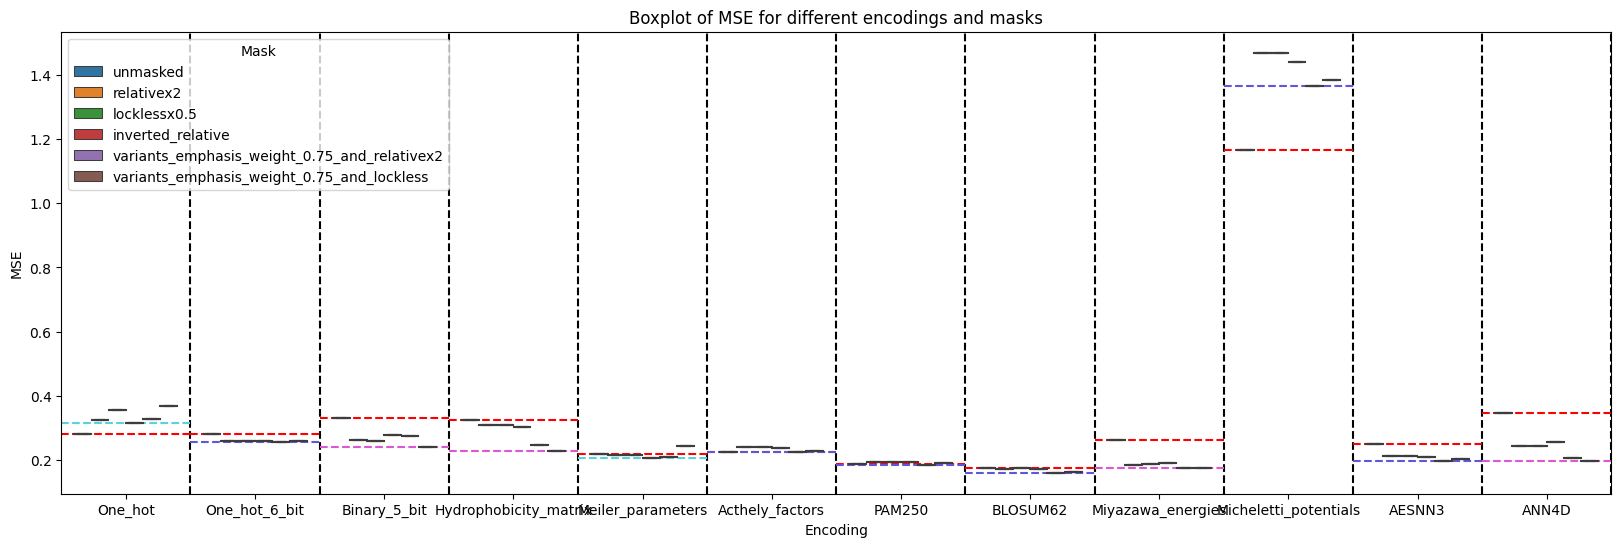

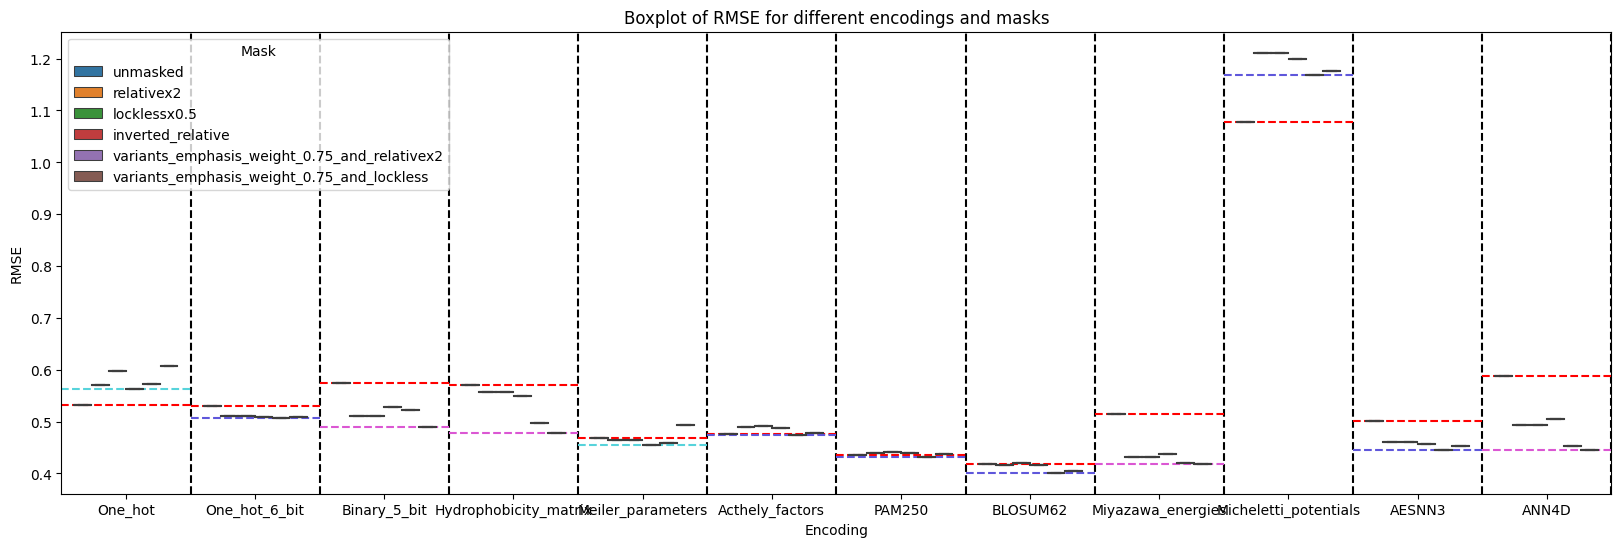

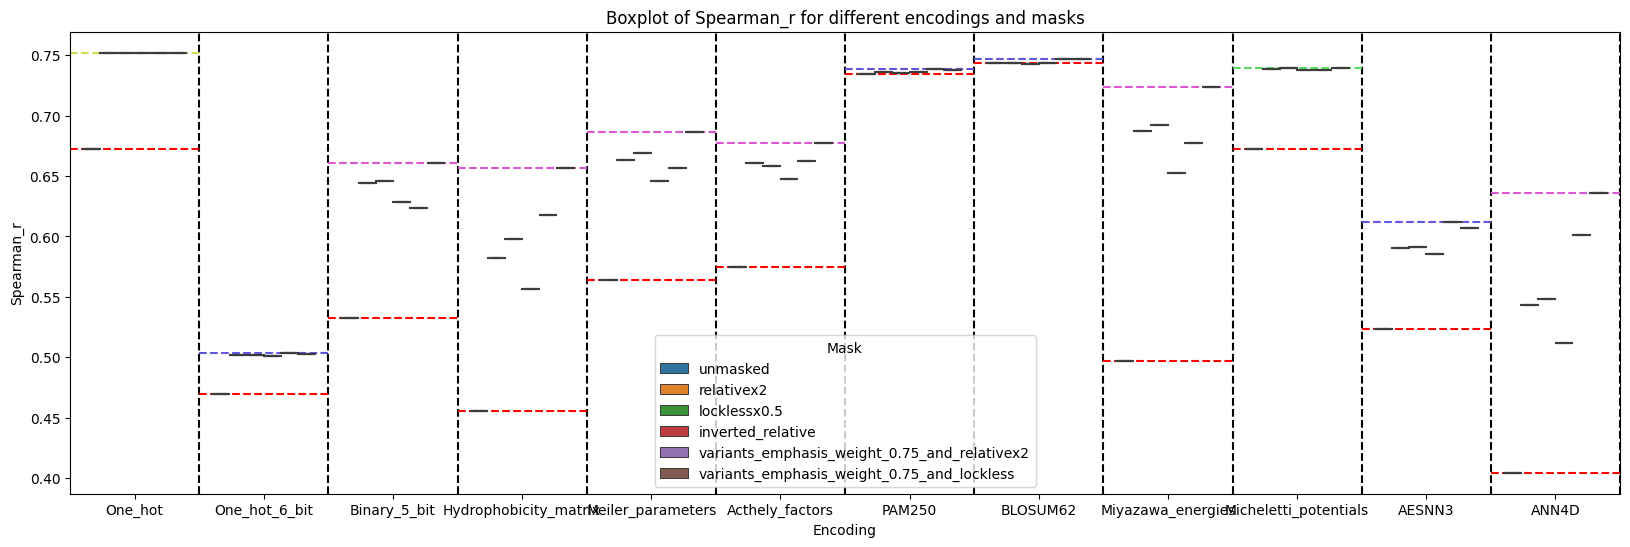

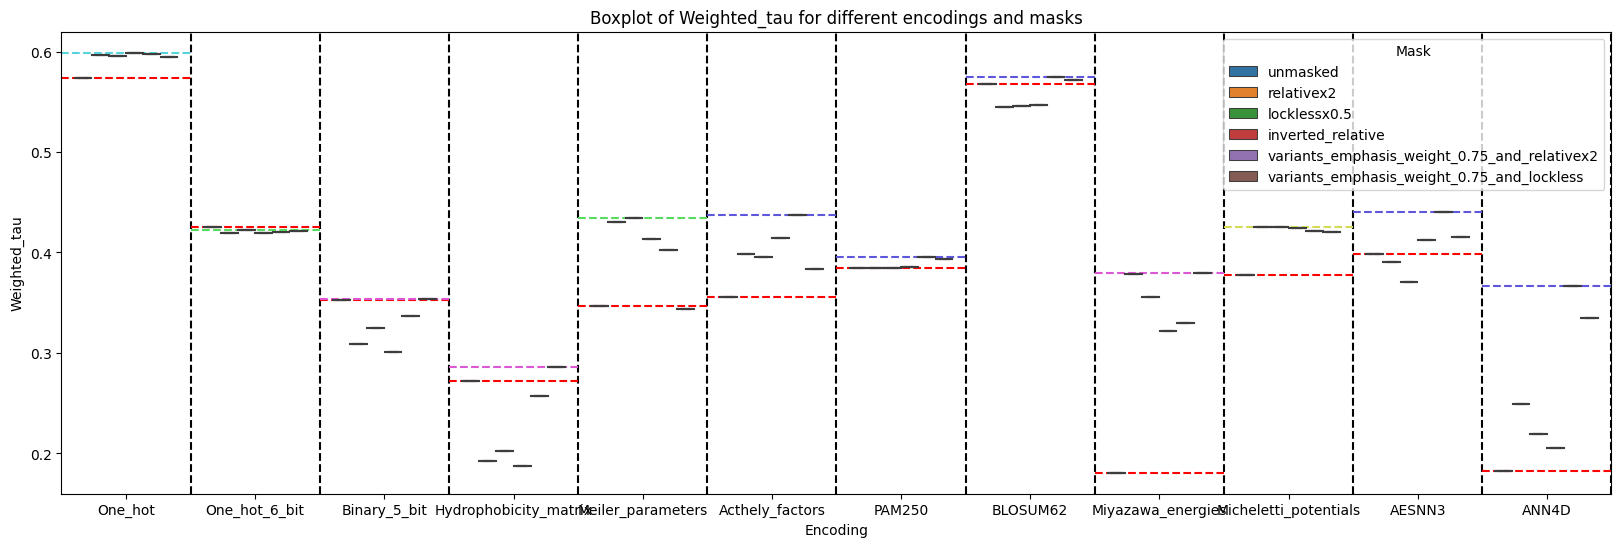

In [50]:
selected_metrics = ["MSE", "RMSE", "Spearman_r", "Weighted_tau"]

#palette = sns.color_palette()
for selected_metric in selected_metrics:
    labeled_size = 1
    # Get unique masks in df
    selected_masks = list(df["Mask"].unique())
    palette = sns.color_palette("hls", len(selected_masks))
    # Boxplot grouped by Encoding
    plt.figure(figsize=(20, 6))
    sns.boxplot(x="Encoding", y=selected_metric, hue="Mask", data=df[df["Labeled"] == labeled_size])
    [plt.axvline(x+0.5, color = 'black', linestyle='--') for x in range(len(encodings))]
    # Draw a horizontal line only in the horizontal space of that group to show the average value of unmasked mask for each encoding group
    for enc in encodings:
        # Get the color used in the boxplot for unmaksed
        color = palette[0]
        plt.axhline(df[(df["Encoding"] == enc) & (df["Labeled"] == labeled_size) & (df["Mask"] == "unmasked")][selected_metric].mean(), 
                    xmin=encodings.index(enc)/len(encodings), xmax=(encodings.index(enc)+1)/len(encodings), 
                    color = "red", linestyle='--')
        # Draw anothe line with the best value other than unmasked
        if selected_metric == 'MSE' or selected_metric == 'RMSE':
            # Get the same color as the boxplot
            best_mask_name = df[(df["Encoding"] == enc) & (df["Labeled"] == labeled_size) & (df["Mask"] != "unmasked")].groupby(["Mask"]).mean()[selected_metric].idxmin()
            best_mask_color = palette[selected_masks.index(best_mask_name)]
            plt.axhline(df[(df["Encoding"] == enc) & (df["Labeled"] == labeled_size) & (df["Mask"] != "unmasked")].groupby(["Mask"]).mean()[selected_metric].min(),
                    xmin=encodings.index(enc)/len(encodings), xmax=(encodings.index(enc)+1)/len(encodings),
                    color = best_mask_color, linestyle='--')
        else:
            # Get the same color as the boxplot
            best_mask_name = df[(df["Encoding"] == enc) & (df["Labeled"] == labeled_size) & (df["Mask"] != "unmasked")].groupby(["Mask"]).mean()[selected_metric].idxmax(),
            best_mask_color = palette[selected_masks.index(best_mask_name[0])]
            plt.axhline(df[(df["Encoding"] == enc) & (df["Labeled"] == labeled_size) & (df["Mask"] != "unmasked")].groupby(["Mask"]).mean()[selected_metric].max(),
                    xmin=encodings.index(enc)/len(encodings), xmax=(encodings.index(enc)+1)/len(encodings),
                    color = best_mask_color, linestyle='--')

    plt.title(f"Boxplot of {selected_metric} for different encodings and masks")
    plt.show()


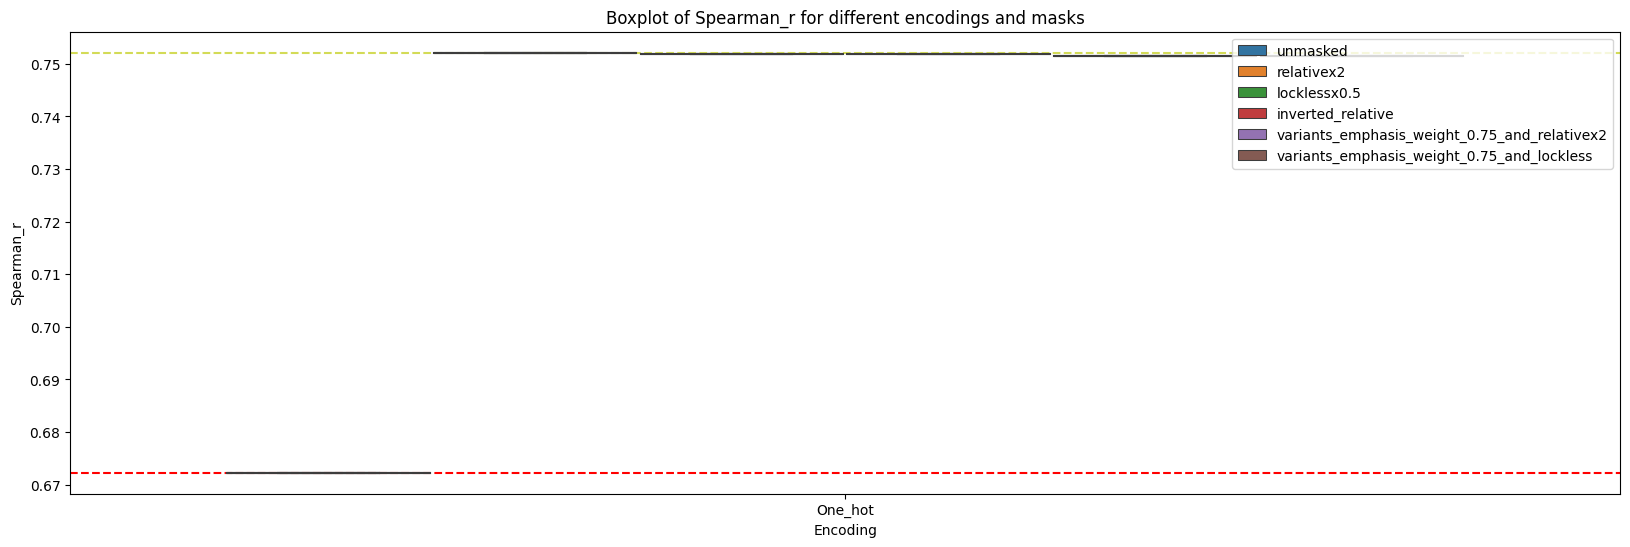

Average value of Spearman_r for unmasked mask for each encoding group
0.6723076742665018
Average value of Spearman_r for relativex2 mask: 0.7521247268921485
Average value of Spearman_r for locklessx0.5 mask: 0.7518687176828424
Average value of Spearman_r for inverted_relative mask: 0.7517860395767163
Average value of Spearman_r for variants_emphasis_weight_0.75_and_relativex2 mask: 0.7514936451260421
Average value of Spearman_r for variants_emphasis_weight_0.75_and_lockless mask: 0.7514024759739206


In [51]:
#selected_metrics = ["MSE", "RMSE", "Spearman_r", "Weighted_tau"]
selected_metrics = ["Spearman_r"]
for selected_metric in selected_metrics:
    labeled_size = 1
    # Get unique masks in df
    selected_masks = list(df["Mask"].unique())
    palette = sns.color_palette("hls", len(selected_masks))

    # Boxplot grouped by Encoding
    plt.figure(figsize=(20, 6))
    sns.boxplot(x="Encoding", y=selected_metric, hue="Mask", data=df[df["Labeled"] == labeled_size & (df["Encoding"] == "One_hot")])
    # Draw a horizontal line only in the horizontal space of that group to show the average value of unmasked mask for each encoding group
    plt.axhline(df[(df["Encoding"] == "One_hot") & (df["Labeled"] == labeled_size) & (df["Mask"] == "unmasked")][selected_metric].mean(),
                        color = 'red', linestyle='--')
    # Draw anothe line with the best value other than unmasked
    if selected_metric == 'MSE' or selected_metric == 'RMSE':
        # Get the same color as the boxplot
        best_mask_name = df[(df["Encoding"] == "One_hot") & (df["Labeled"] == labeled_size) & (df["Mask"] != "unmasked")].groupby(["Mask"]).mean()[selected_metric].idxmin(),
        best_mask_color = palette[selected_masks.index(best_mask_name[0])]
        plt.axhline(df[(df["Encoding"] == "One_hot") & (df["Labeled"] == labeled_size) & (df["Mask"] != "unmasked")].groupby(["Mask"]).mean()[selected_metric].min(),
                    color = best_mask_color, linestyle='--')
    else:
        # Get the same color as the boxplot
        best_mask_name = df[(df["Encoding"] == "One_hot") & (df["Labeled"] == labeled_size) & (df["Mask"] != "unmasked")].groupby(["Mask"]).mean()[selected_metric].idxmax(),
        best_mask_color = palette[selected_masks.index(best_mask_name[0])]
        plt.axhline(df[(df["Encoding"] == "One_hot") & (df["Labeled"] == labeled_size) & (df["Mask"] != "unmasked")].groupby(["Mask"]).mean()[selected_metric].max(),
                    color = best_mask_color, linestyle='--')

    plt.title(f"Boxplot of {selected_metric} for different encodings and masks")
    plt.legend(loc='upper right')
    plt.show()

# Print the plotted values
labeled_size = 1
for selected_metric in selected_metrics:
    print(f"Average value of {selected_metric} for unmasked mask for each encoding group")
    print(df[(df["Encoding"] == "One_hot") & (df["Labeled"] == labeled_size) & (df["Mask"] == "unmasked")][selected_metric].mean())
    for mask in selected_masks:
        if mask != "unmasked":
            value = df[(df["Encoding"] == "One_hot") & (df["Labeled"] == labeled_size) & (df["Mask"] == mask)][selected_metric].mean()
            if value > 0:
                print(f"Average value of {selected_metric} for {mask} mask: {value}")



/tmp/ipykernel_2734983/32968630.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  boxplot_df['Mean_train_size'] = boxplot_df.groupby(['Labeled', 'Encoding'])['Train_size'].transform('mean').round(0).astype(int)
/tmp/ipykernel_2734983/32968630.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  boxplot_df['Labeled_Train_size'] = boxplot_df['Labeled'].astype(str) + '\n\n' + boxplot_df['Mean_train_size'].astype(str)


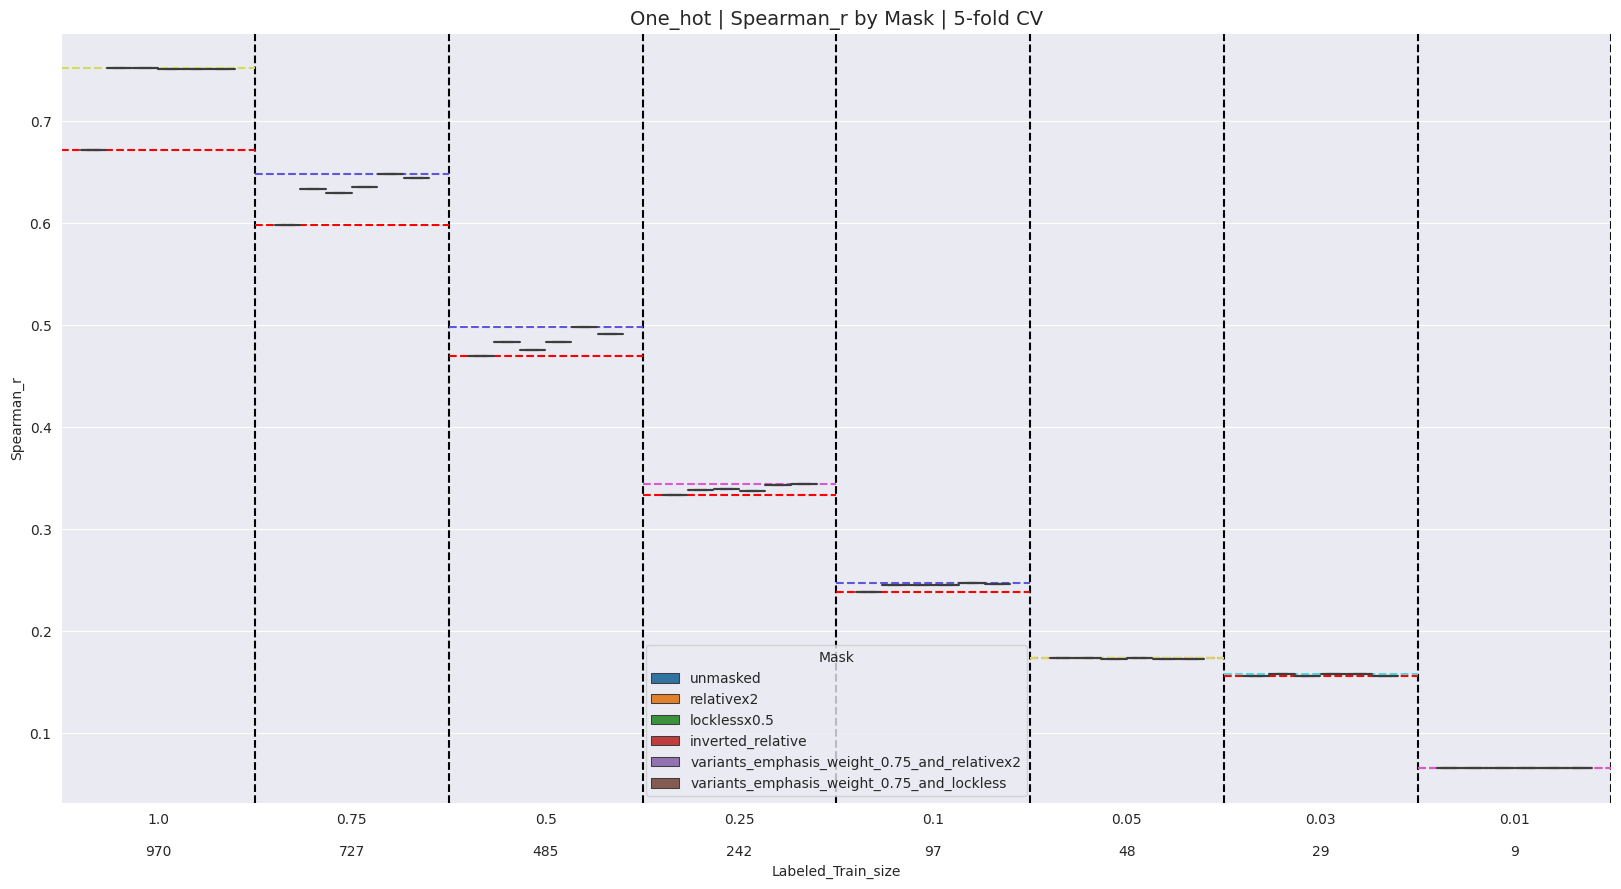

/tmp/ipykernel_2734983/32968630.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  boxplot_df['Mean_train_size'] = boxplot_df.groupby(['Labeled', 'Encoding'])['Train_size'].transform('mean').round(0).astype(int)
/tmp/ipykernel_2734983/32968630.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  boxplot_df['Labeled_Train_size'] = boxplot_df['Labeled'].astype(str) + '\n\n' + boxplot_df['Mean_train_size'].astype(str)


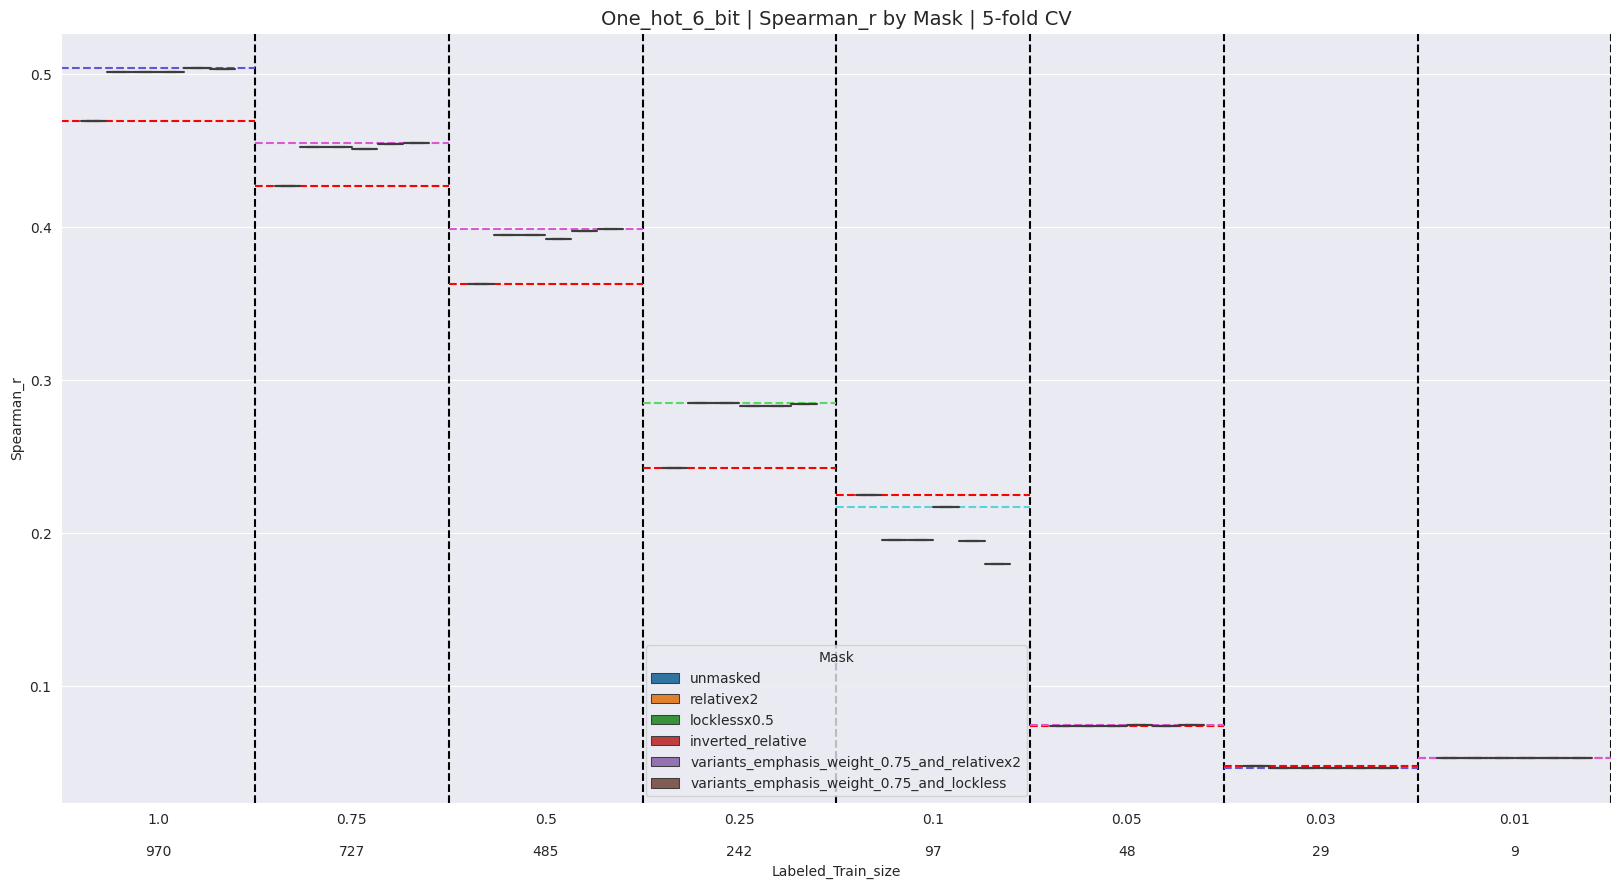

/tmp/ipykernel_2734983/32968630.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  boxplot_df['Mean_train_size'] = boxplot_df.groupby(['Labeled', 'Encoding'])['Train_size'].transform('mean').round(0).astype(int)
/tmp/ipykernel_2734983/32968630.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  boxplot_df['Labeled_Train_size'] = boxplot_df['Labeled'].astype(str) + '\n\n' + boxplot_df['Mean_train_size'].astype(str)


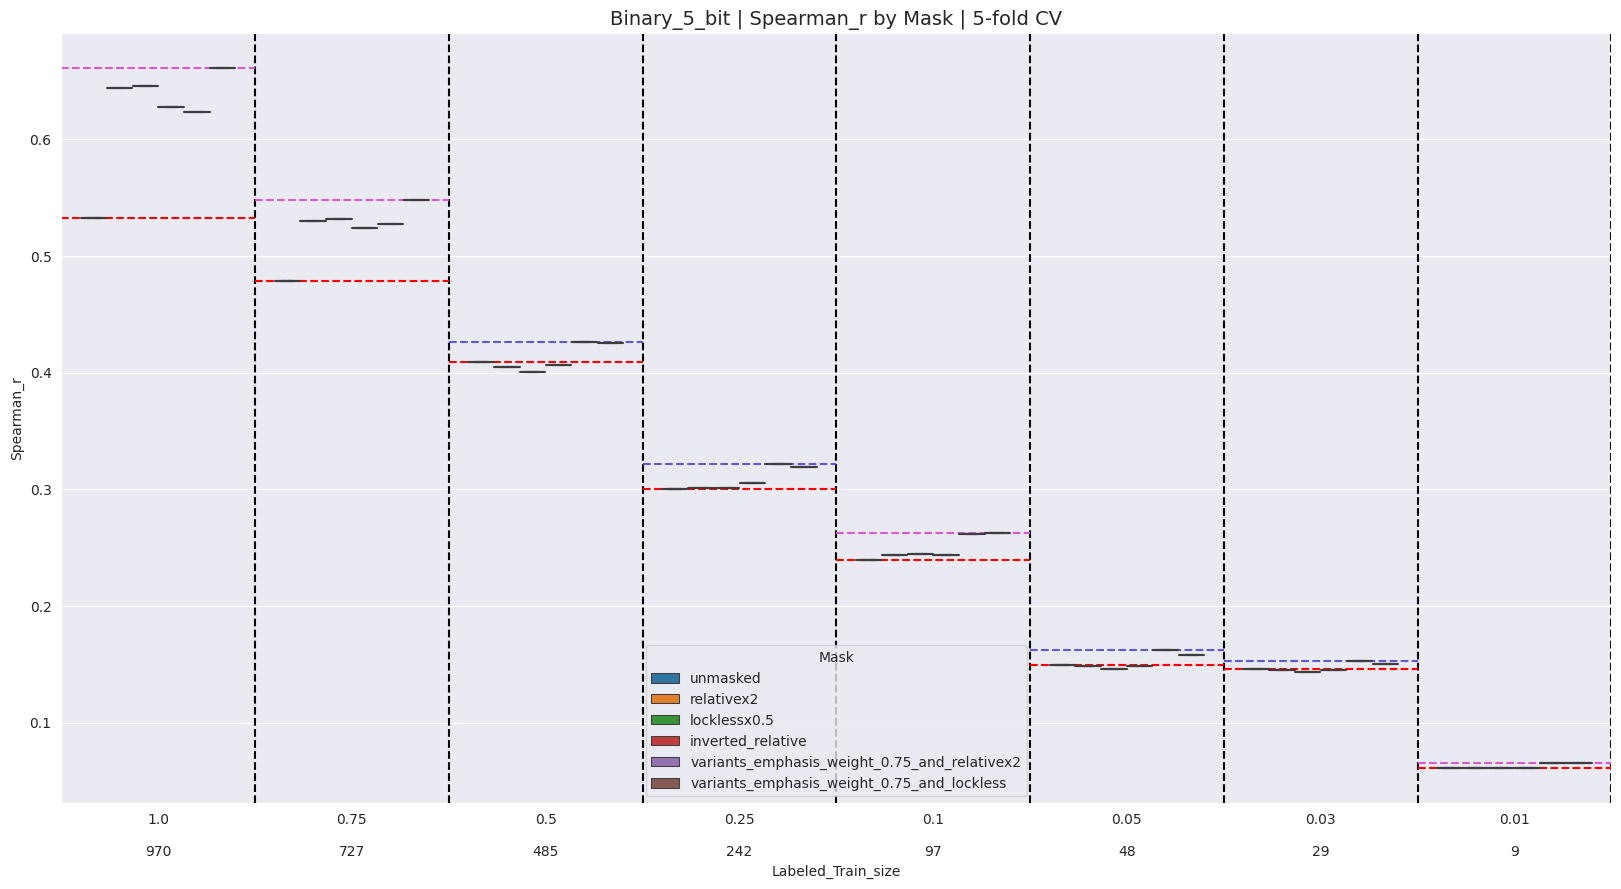

/tmp/ipykernel_2734983/32968630.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  boxplot_df['Mean_train_size'] = boxplot_df.groupby(['Labeled', 'Encoding'])['Train_size'].transform('mean').round(0).astype(int)
/tmp/ipykernel_2734983/32968630.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  boxplot_df['Labeled_Train_size'] = boxplot_df['Labeled'].astype(str) + '\n\n' + boxplot_df['Mean_train_size'].astype(str)


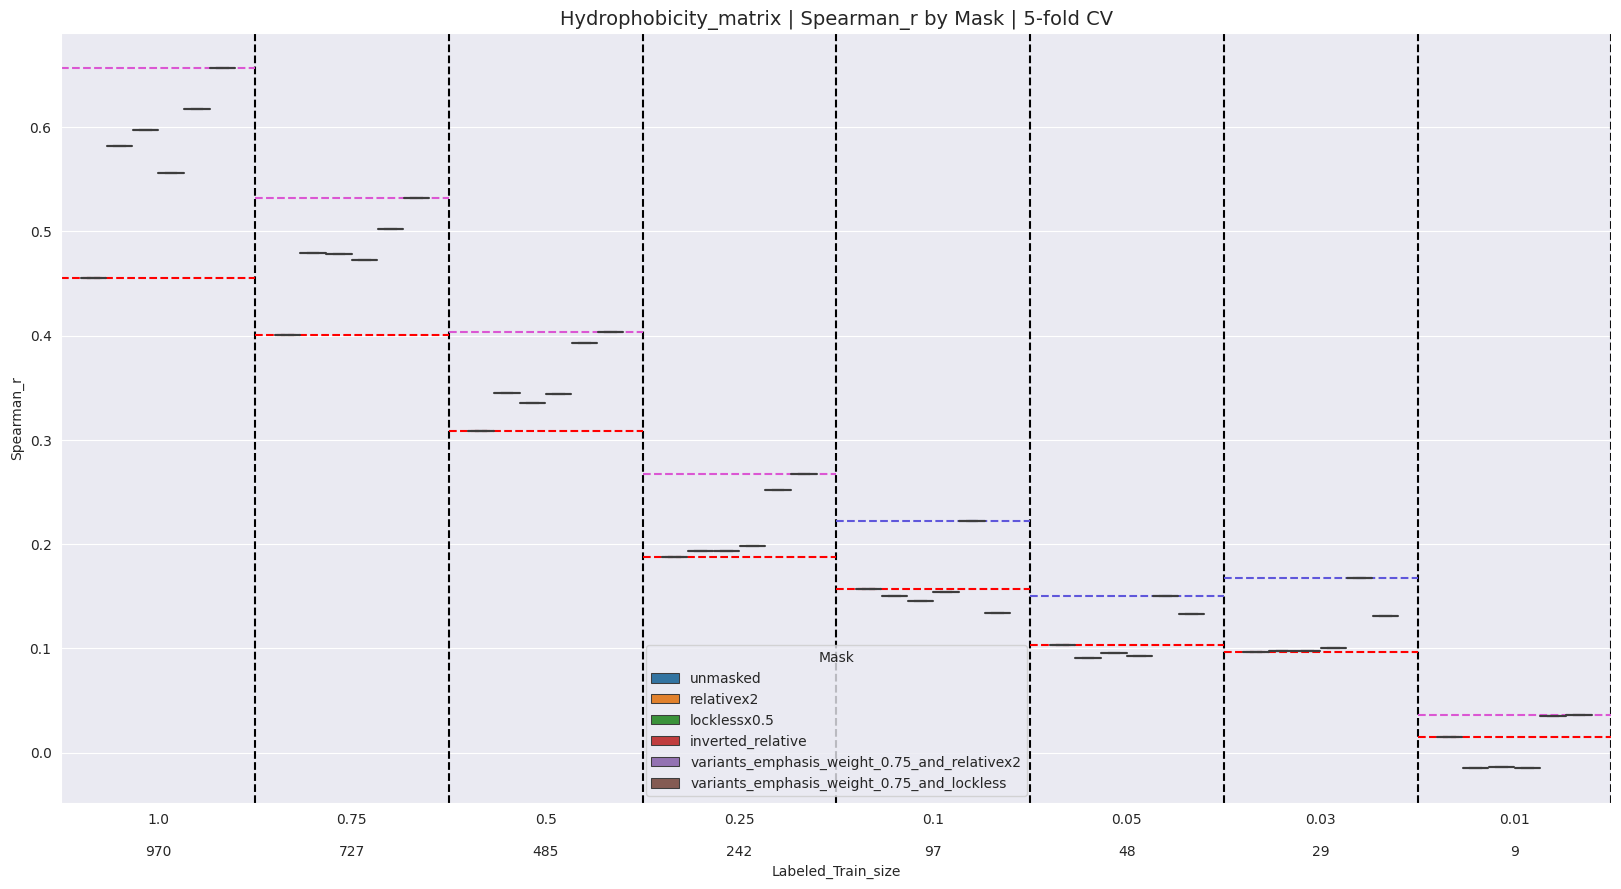

/tmp/ipykernel_2734983/32968630.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  boxplot_df['Mean_train_size'] = boxplot_df.groupby(['Labeled', 'Encoding'])['Train_size'].transform('mean').round(0).astype(int)
/tmp/ipykernel_2734983/32968630.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  boxplot_df['Labeled_Train_size'] = boxplot_df['Labeled'].astype(str) + '\n\n' + boxplot_df['Mean_train_size'].astype(str)


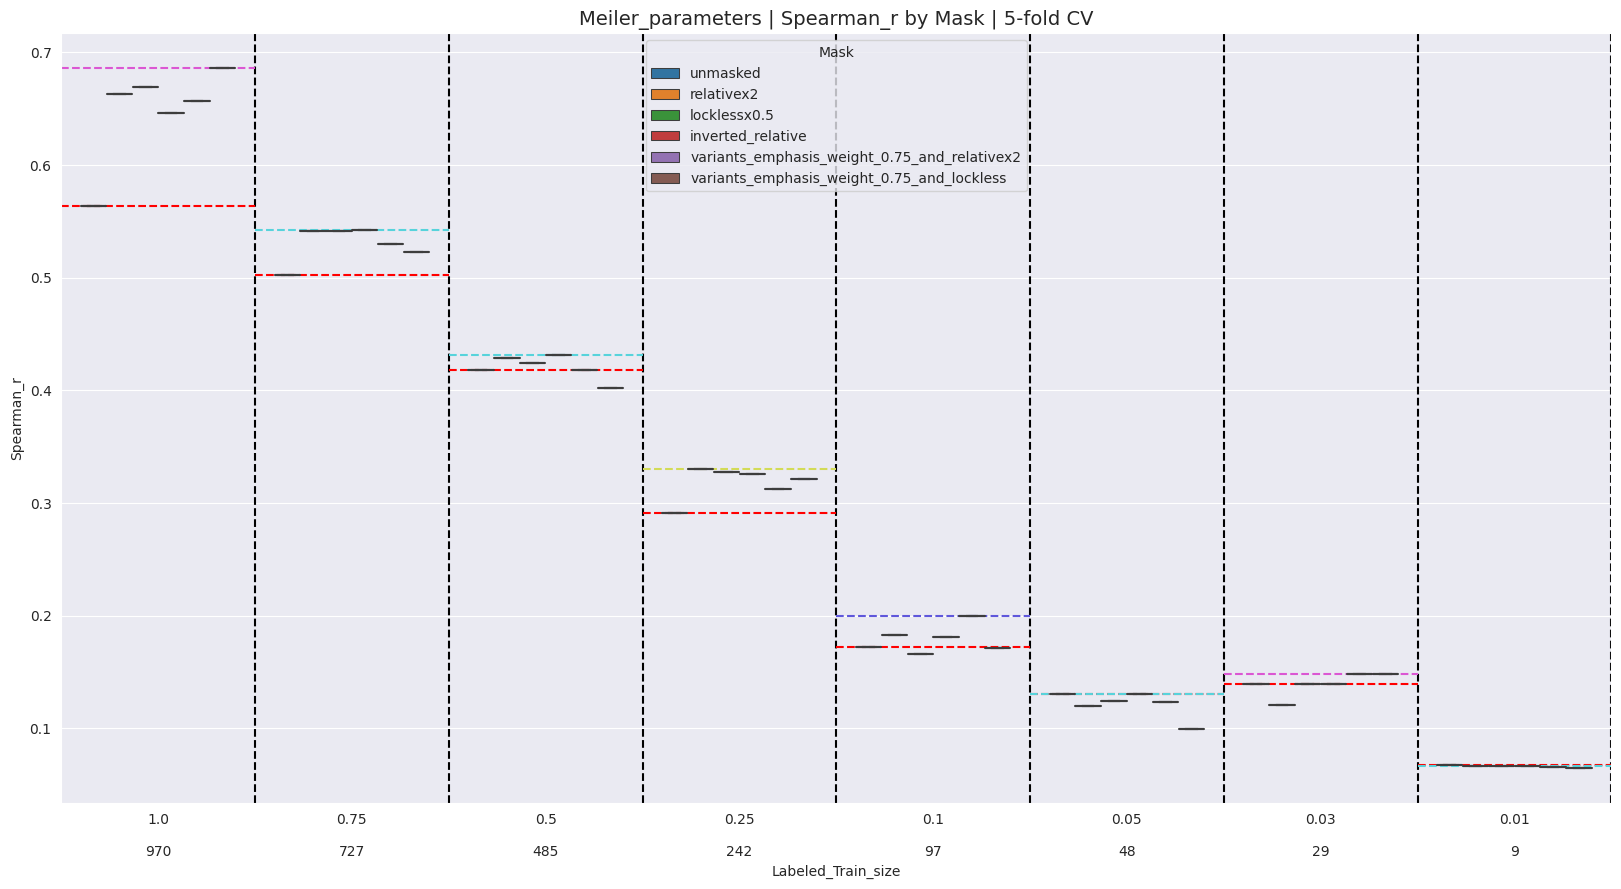

/tmp/ipykernel_2734983/32968630.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  boxplot_df['Mean_train_size'] = boxplot_df.groupby(['Labeled', 'Encoding'])['Train_size'].transform('mean').round(0).astype(int)
/tmp/ipykernel_2734983/32968630.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  boxplot_df['Labeled_Train_size'] = boxplot_df['Labeled'].astype(str) + '\n\n' + boxplot_df['Mean_train_size'].astype(str)


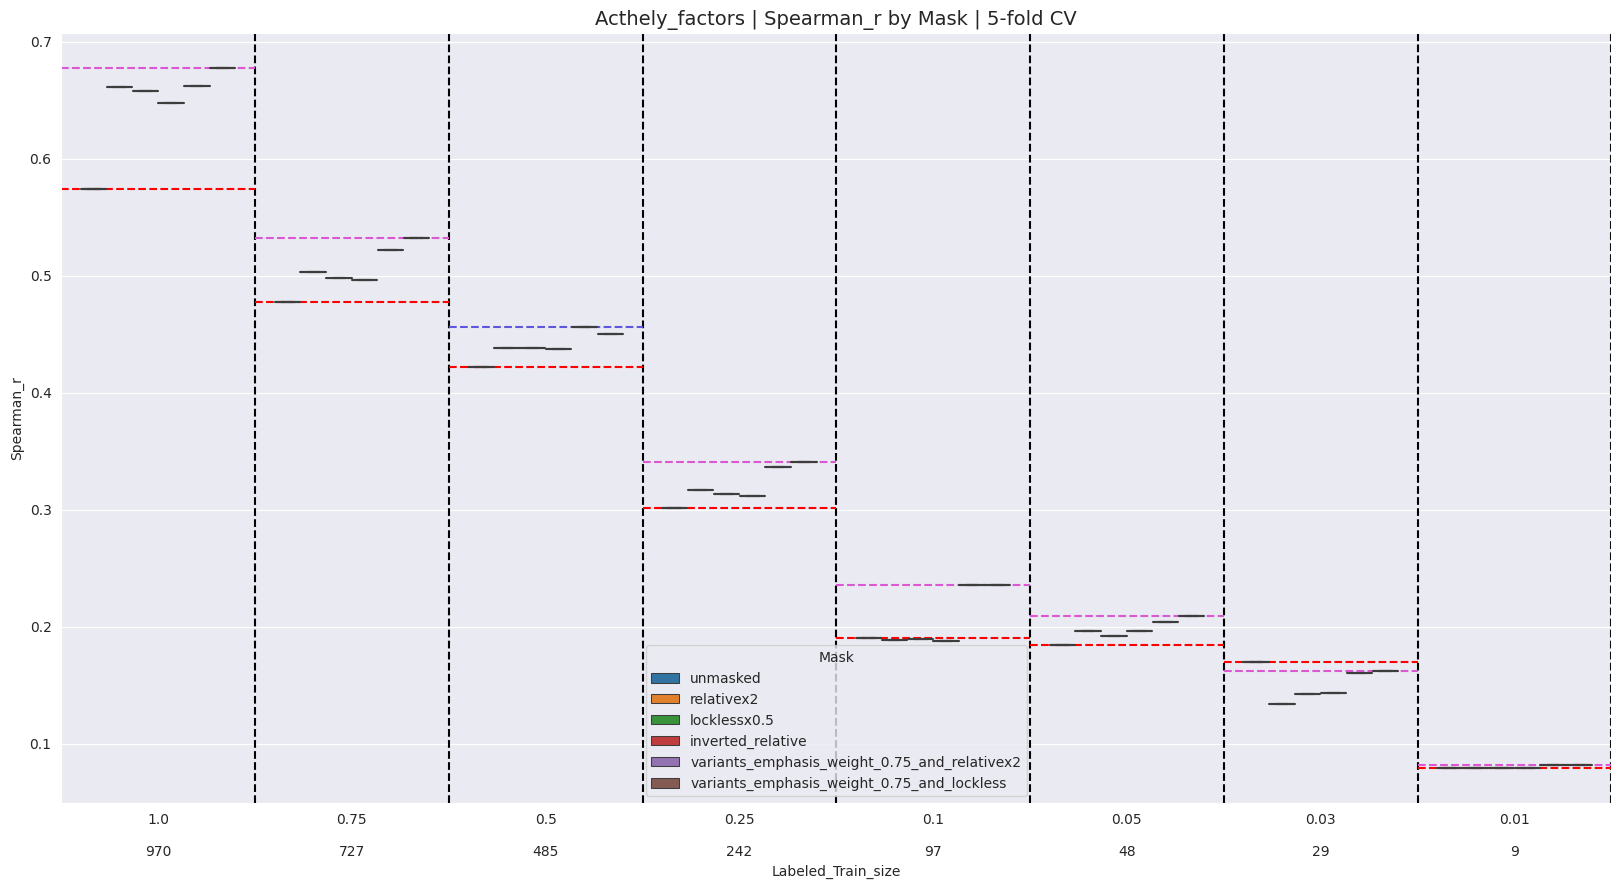

/tmp/ipykernel_2734983/32968630.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  boxplot_df['Mean_train_size'] = boxplot_df.groupby(['Labeled', 'Encoding'])['Train_size'].transform('mean').round(0).astype(int)
/tmp/ipykernel_2734983/32968630.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  boxplot_df['Labeled_Train_size'] = boxplot_df['Labeled'].astype(str) + '\n\n' + boxplot_df['Mean_train_size'].astype(str)


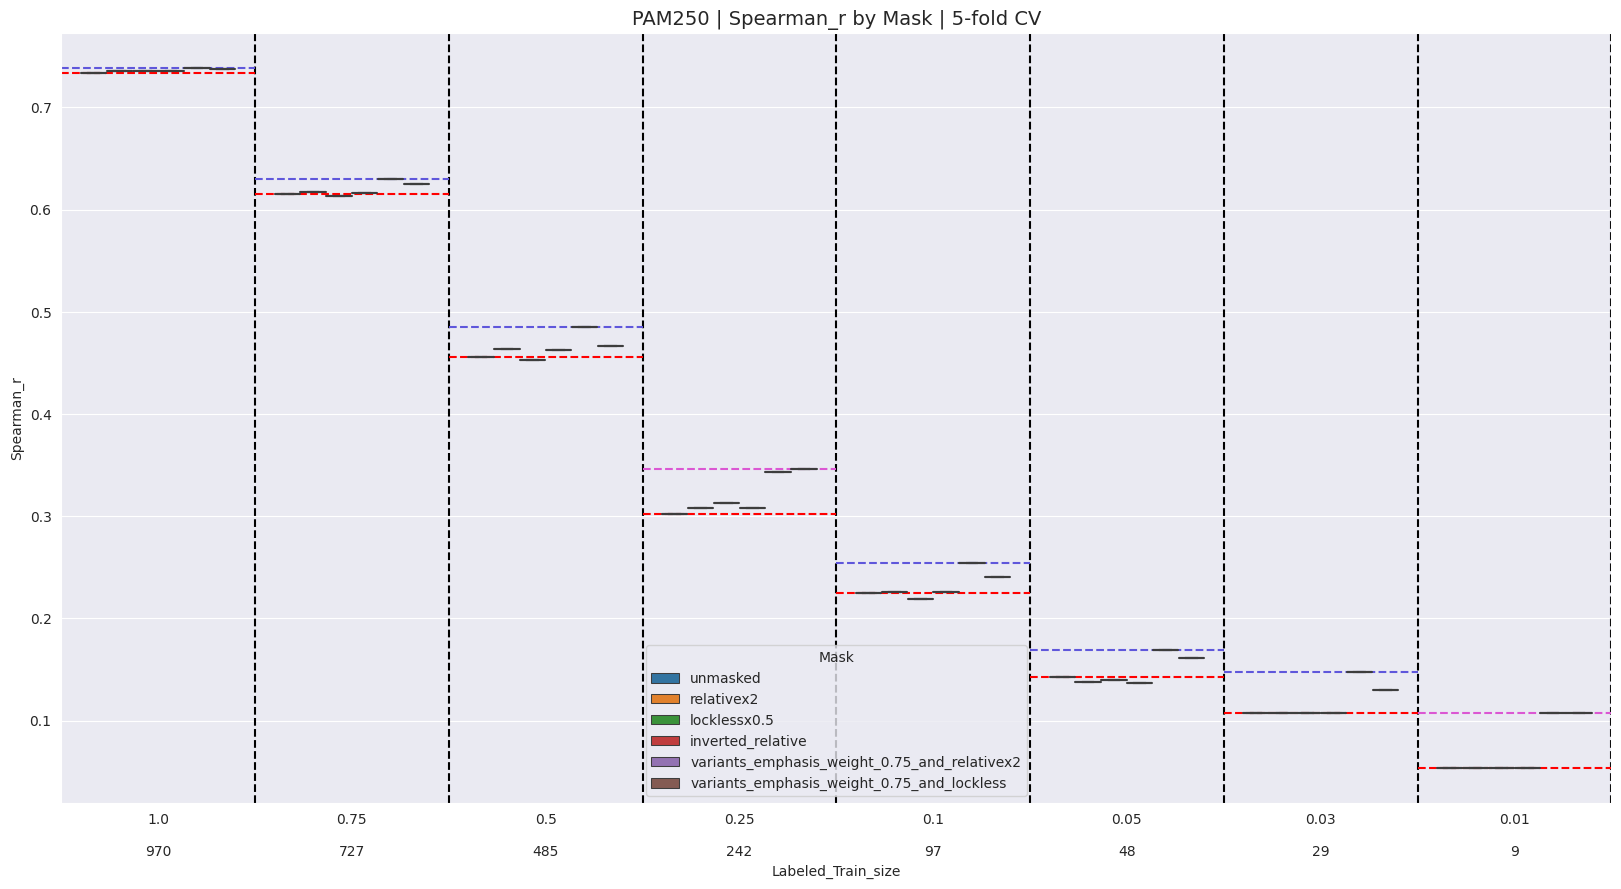

/tmp/ipykernel_2734983/32968630.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  boxplot_df['Mean_train_size'] = boxplot_df.groupby(['Labeled', 'Encoding'])['Train_size'].transform('mean').round(0).astype(int)
/tmp/ipykernel_2734983/32968630.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  boxplot_df['Labeled_Train_size'] = boxplot_df['Labeled'].astype(str) + '\n\n' + boxplot_df['Mean_train_size'].astype(str)


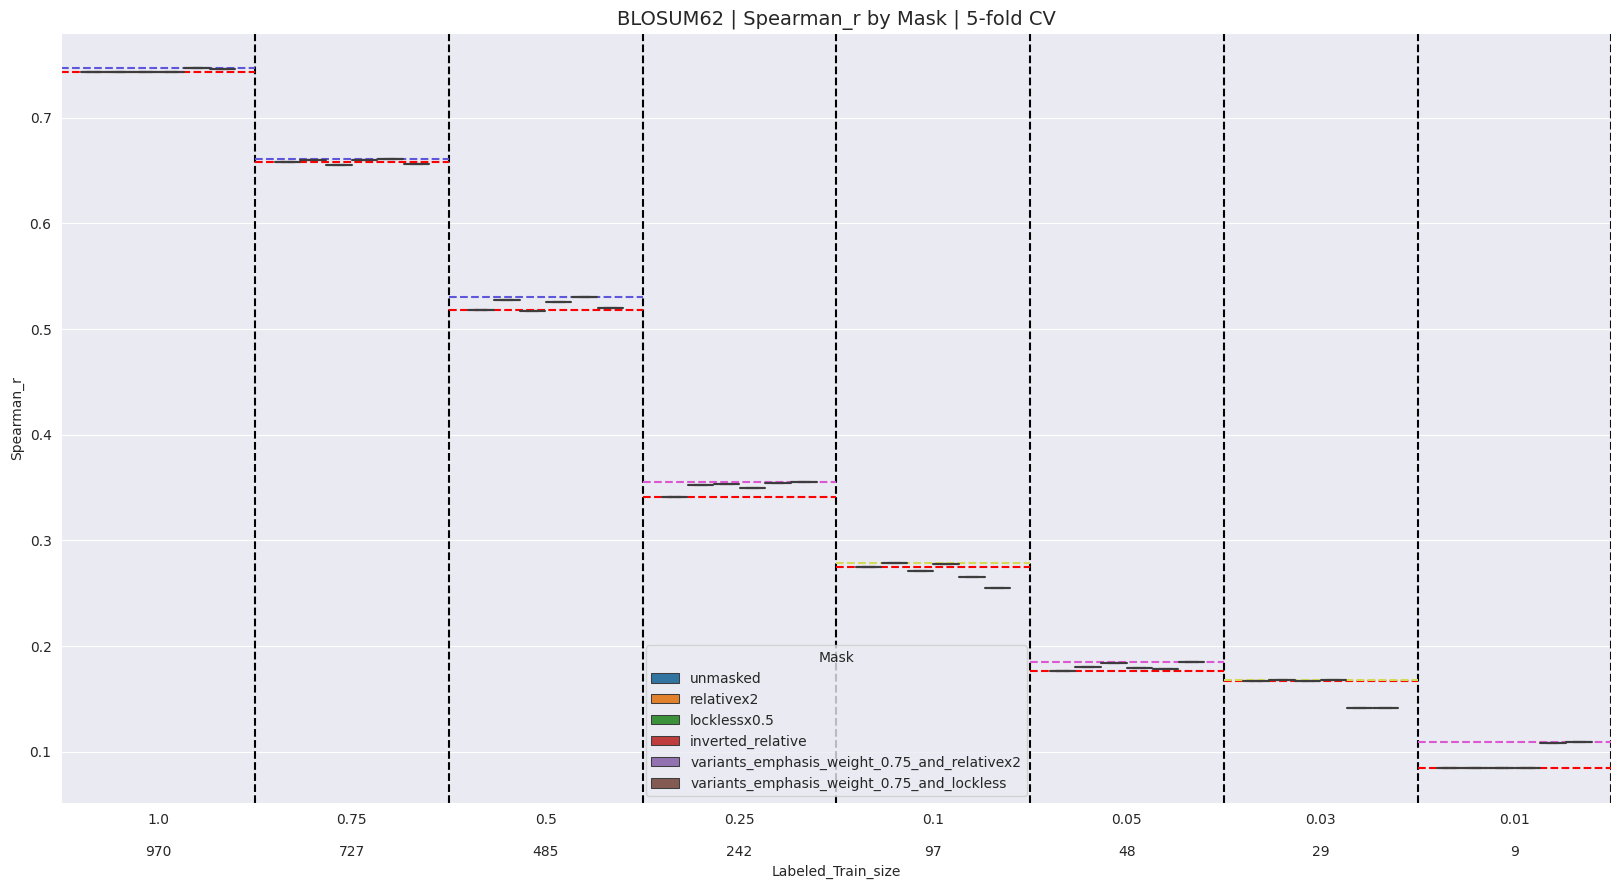

/tmp/ipykernel_2734983/32968630.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  boxplot_df['Mean_train_size'] = boxplot_df.groupby(['Labeled', 'Encoding'])['Train_size'].transform('mean').round(0).astype(int)
/tmp/ipykernel_2734983/32968630.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  boxplot_df['Labeled_Train_size'] = boxplot_df['Labeled'].astype(str) + '\n\n' + boxplot_df['Mean_train_size'].astype(str)


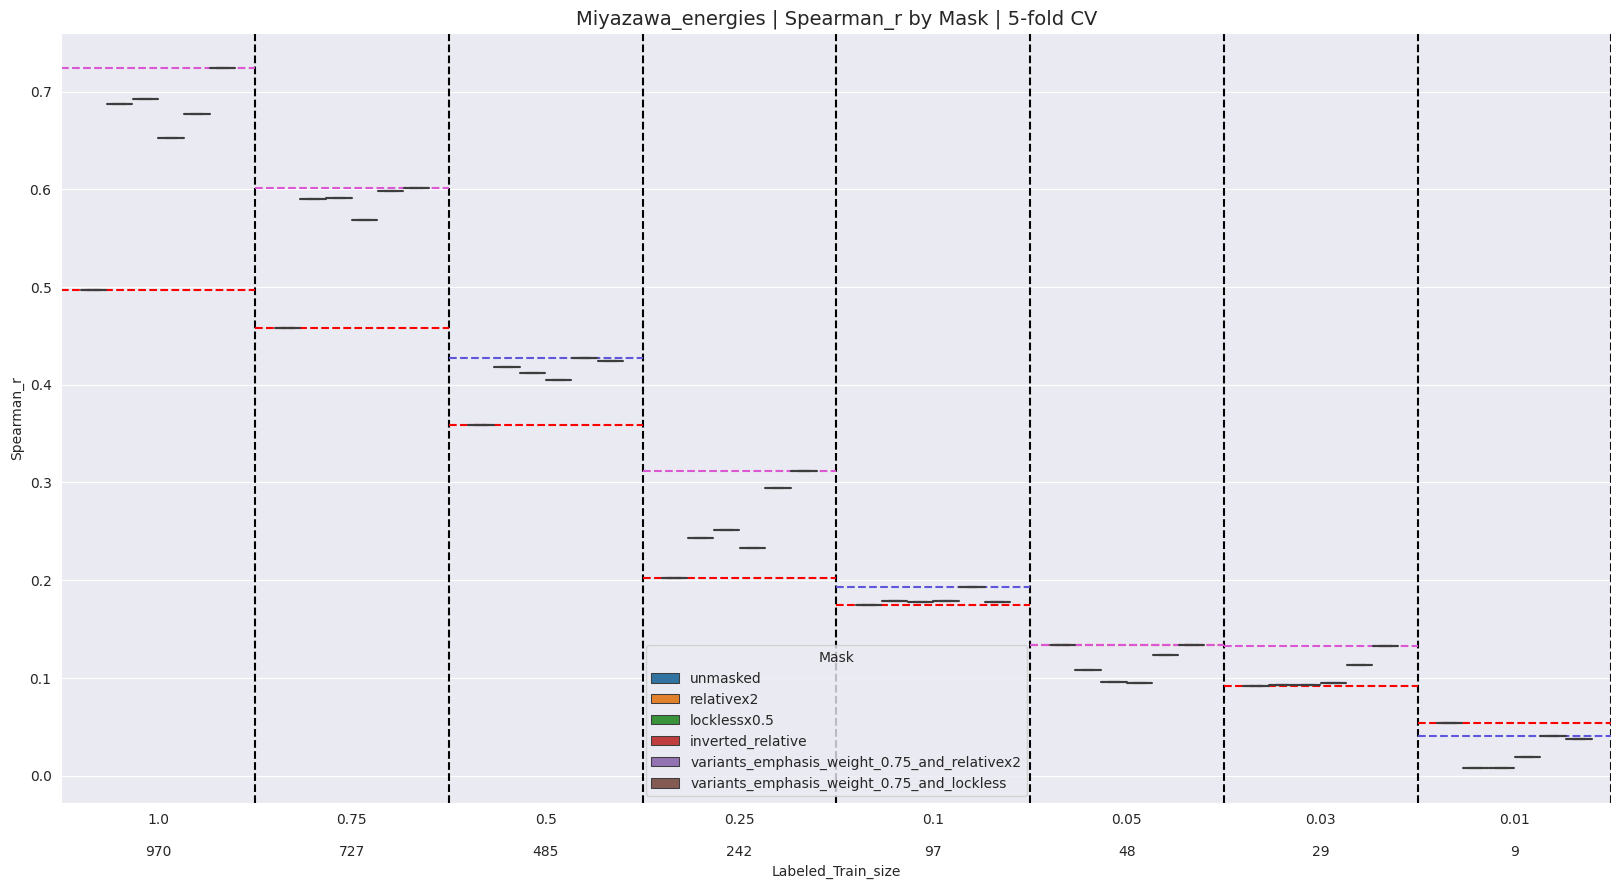

/tmp/ipykernel_2734983/32968630.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  boxplot_df['Mean_train_size'] = boxplot_df.groupby(['Labeled', 'Encoding'])['Train_size'].transform('mean').round(0).astype(int)
/tmp/ipykernel_2734983/32968630.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  boxplot_df['Labeled_Train_size'] = boxplot_df['Labeled'].astype(str) + '\n\n' + boxplot_df['Mean_train_size'].astype(str)


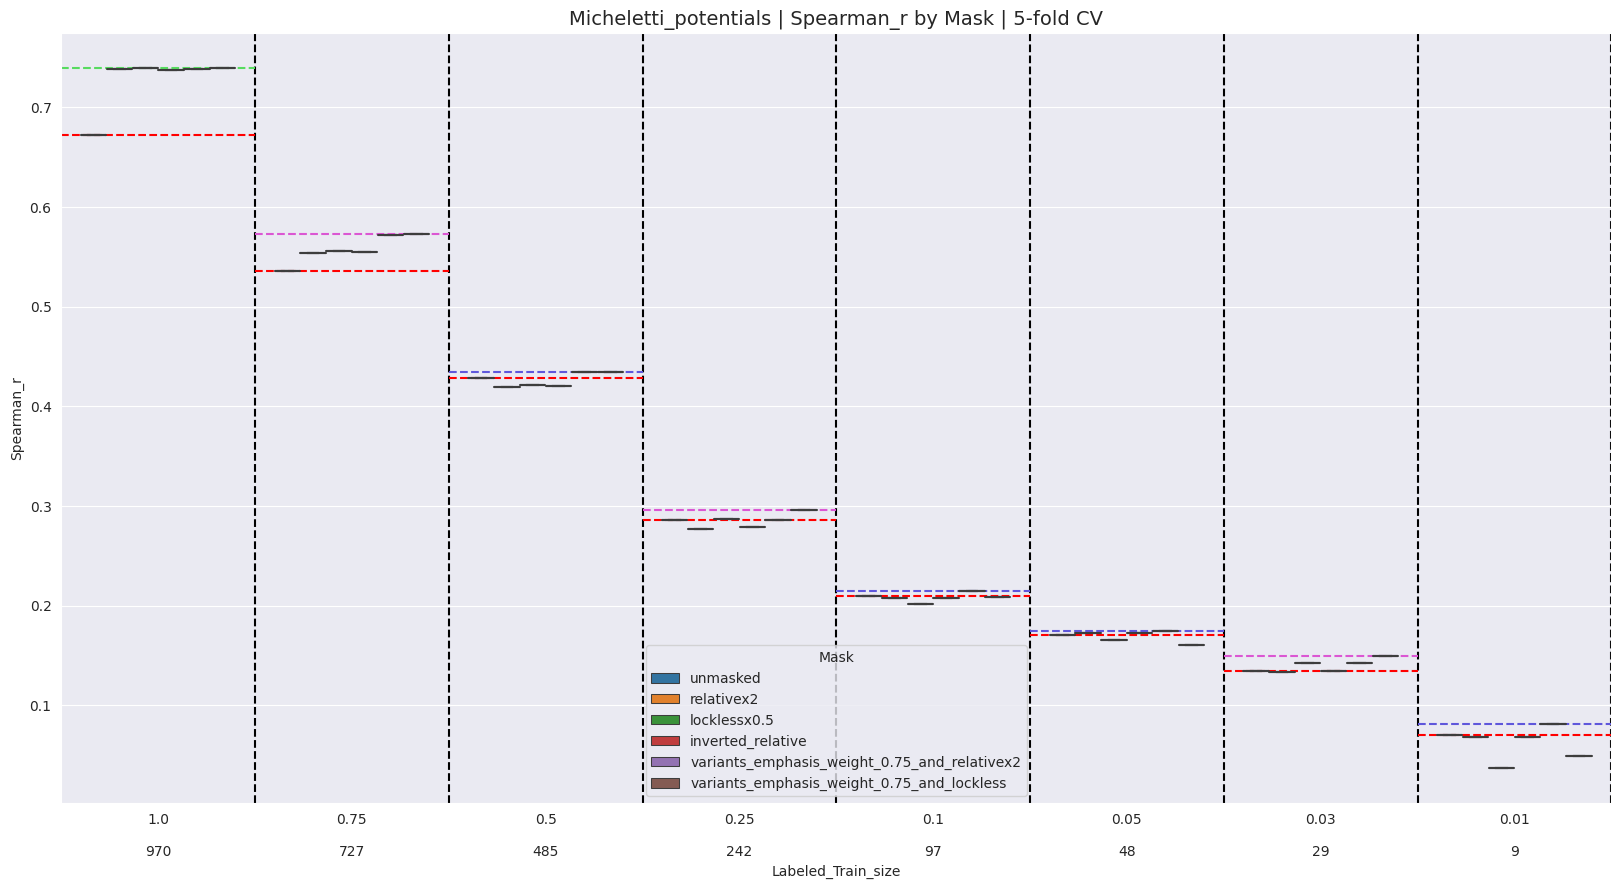

/tmp/ipykernel_2734983/32968630.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  boxplot_df['Mean_train_size'] = boxplot_df.groupby(['Labeled', 'Encoding'])['Train_size'].transform('mean').round(0).astype(int)
/tmp/ipykernel_2734983/32968630.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  boxplot_df['Labeled_Train_size'] = boxplot_df['Labeled'].astype(str) + '\n\n' + boxplot_df['Mean_train_size'].astype(str)


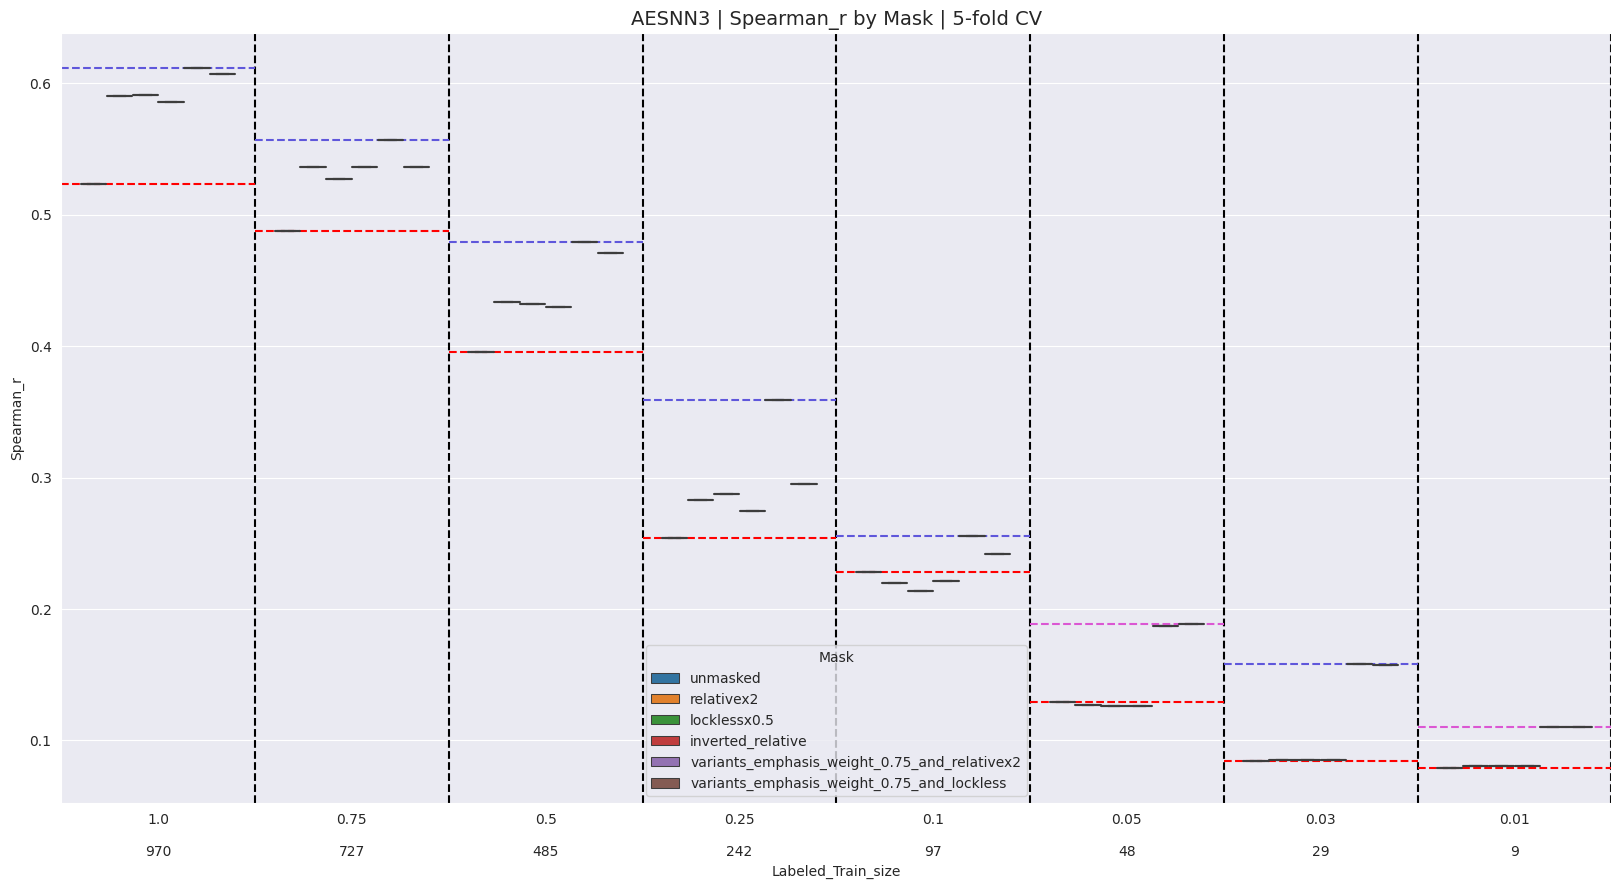

/tmp/ipykernel_2734983/32968630.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  boxplot_df['Mean_train_size'] = boxplot_df.groupby(['Labeled', 'Encoding'])['Train_size'].transform('mean').round(0).astype(int)
/tmp/ipykernel_2734983/32968630.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  boxplot_df['Labeled_Train_size'] = boxplot_df['Labeled'].astype(str) + '\n\n' + boxplot_df['Mean_train_size'].astype(str)


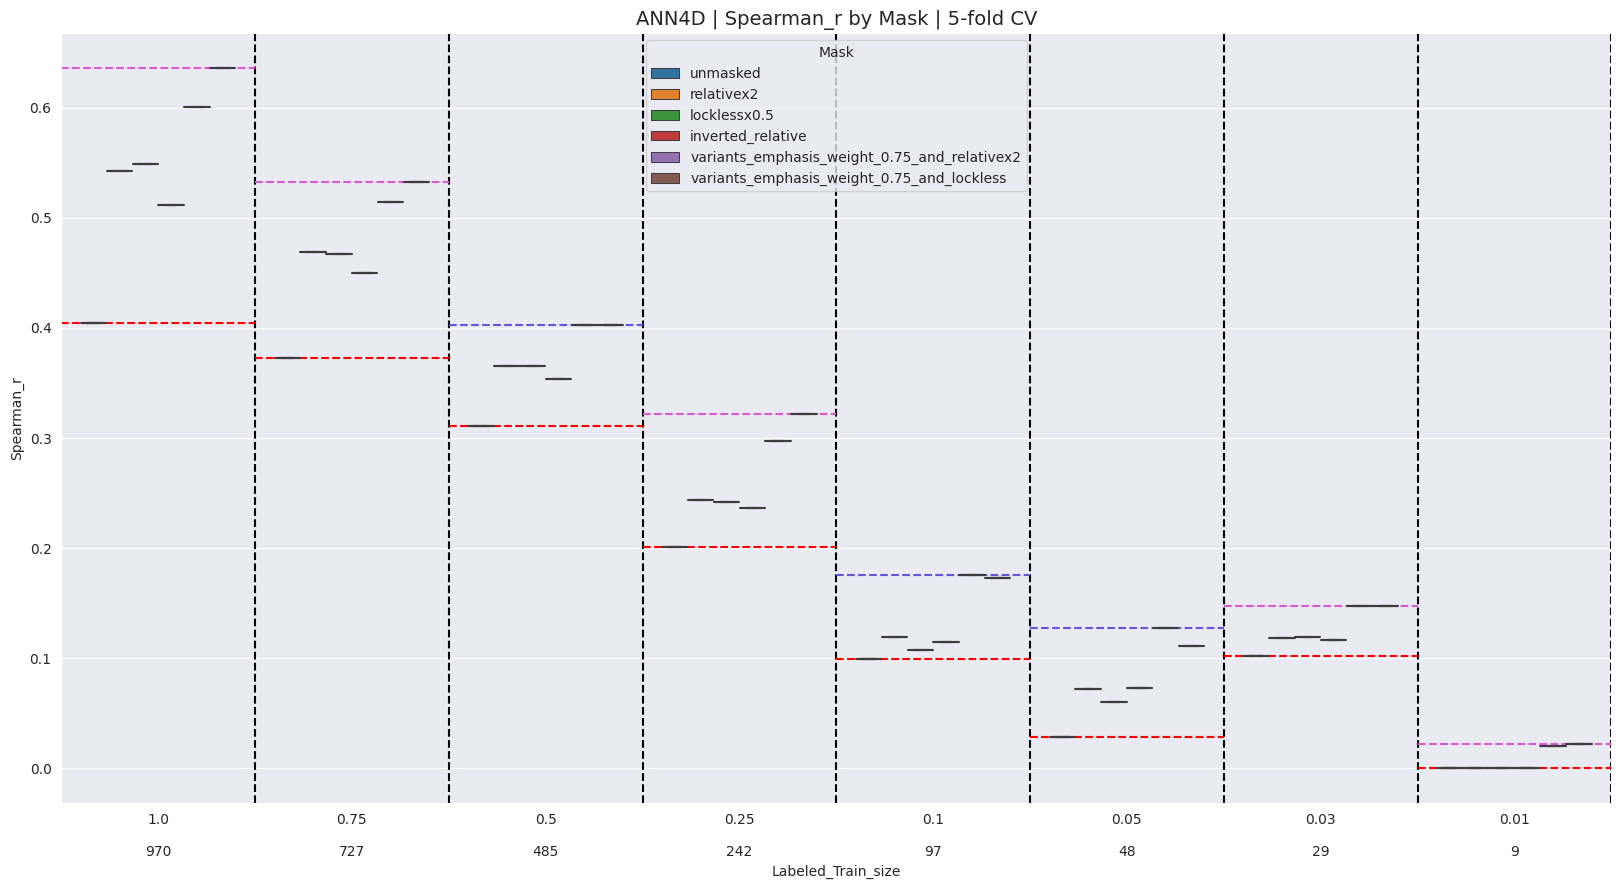

In [52]:
selected_metric = "Spearman_r"
for enc in encodings:

    # Get unique masks in df
    selected_masks = list(df["Mask"].unique())
    palette = sns.color_palette("hls", len(selected_masks))
    
    plt.figure(figsize=(20, 10))

    boxplot_df = df.loc[(df["Encoding"] == enc)]
    boxplot_df['Mean_train_size'] = boxplot_df.groupby(['Labeled', 'Encoding'])['Train_size'].transform('mean').round(0).astype(int)
    boxplot_df['Labeled_Train_size'] = boxplot_df['Labeled'].astype(str) + '\n\n' + boxplot_df['Mean_train_size'].astype(str)
    # Boxplot grouped by labeled
    # Vertical and horizontal grid background
    sns.set_style("darkgrid")
    sns.boxplot(x="Labeled_Train_size", y=selected_metric, hue="Mask", data=boxplot_df)
    [plt.axvline(x+0.5, color = 'black', linestyle='--') for x in range(len(labeled_sizes))]
    # Draw a horizontal line only in the horizontal space of that group to show the average value of unmasked mask for each labeled group
    for labeled in labeled_sizes_list:
        plt.axhline(df[(df["Encoding"] == enc) & (df["Labeled"] == labeled) & (df["Mask"] == "unmasked")][selected_metric].mean(), 
                    xmin=labeled_sizes_list.index(labeled)/len(labeled_sizes_list), xmax=(labeled_sizes_list.index(labeled)+1)/len(labeled_sizes_list), 
                    color = 'red', linestyle='--')
        # Draw anothe line with the best value other than unmasked
        if selected_metric == 'MSE' or selected_metric == 'RMSE':
            # Get the same color as the boxplot
            best_mask_name = df[(df["Encoding"] == enc) & (df["Labeled"] == labeled) & (df["Mask"] != "unmasked")].groupby(["Mask"]).mean()[selected_metric].idxmin(),
            best_mask_color = palette[selected_masks.index(best_mask_name[0])]
            plt.axhline(df[(df["Encoding"] == enc) & (df["Labeled"] == labeled) & (df["Mask"] != "unmasked")].groupby(["Mask"]).mean()[selected_metric].min(),
                        xmin=labeled_sizes_list.index(labeled)/len(labeled_sizes_list), xmax=(labeled_sizes_list.index(labeled)+1)/len(labeled_sizes_list),
                        color = best_mask_color, linestyle='--')
        else:
            # Get the same color as the boxplot
            best_mask_name = df[(df["Encoding"] == enc) & (df["Labeled"] == labeled) & (df["Mask"] != "unmasked")].groupby(["Mask"]).mean()[selected_metric].idxmax(),
            best_mask_color = palette[selected_masks.index(best_mask_name[0])]
            plt.axhline(df[(df["Encoding"] == enc) & (df["Labeled"] == labeled) & (df["Mask"] != "unmasked")].groupby(["Mask"]).mean()[selected_metric].max(),
                        xmin=labeled_sizes_list.index(labeled)/len(labeled_sizes_list), xmax=(labeled_sizes_list.index(labeled)+1)/len(labeled_sizes_list),
                        color = best_mask_color, linestyle='--')
                        

    plt.title(f'{enc} | {selected_metric} by Mask | 5-fold CV', fontsize=14)
    plt.show()